In [44]:
import tensorflow as tf
import tensorflow.keras as keras
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  
import os
import shap


from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [45]:
## This is a function that shows the shap values for a given mnist image
def mnist_shap_plot(index, X_data, y_true, y_pred, shap_values, class_names):
    """
    Plots an MNIST image, its true & predicted label, and its SHAP values for all classes.

    Parameters:
    - index: Index of the sample to plot
    - X_data: The dataset of images (should be shaped as (n_samples, 28, 28, 1))
    - y_true: The true labels
    - y_pred: The predicted labels
    - shap_values: The SHAP values (expected shape: (n_samples, 28, 28, 1, 10))
    - class_names: List of class names (0-9)
    """
    
    # Extract relevant data
    test_image = X_data[index].reshape(28, 28)  # Ensure correct shape
    true_label = class_names[y_true[index]]
    pred_label = class_names[y_pred[index]]

    # Compute global color scale for SHAP values across all classes
    vmin = shap_values[index, :, :, 0, :].min()
    vmax = shap_values[index, :, :, 0, :].max()

    # Set up the grid for plotting (1 row for image, 2 rows for SHAP explanations)
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(3, 6, width_ratios=[1, 1, 1, 1, 1, 0.2])  # Last column for colorbar

    # Plot the original image at the top
    ax = plt.subplot(gs[0, 1:4])  # Center the image in the top row
    ax.imshow(test_image, cmap="binary", interpolation="nearest")
    ax.axis('off')
    ax.set_title(f"True: {true_label} | Pred: {pred_label}", fontsize=10, color="red" if true_label != pred_label else "black")

    # Loop through digit classes (0-9) and plot SHAP explanations in a 2-row grid
    for digit in range(10):
        ax = plt.subplot(gs[1 + digit // 5, digit % 5])  # Correct 2-row layout

        # Extract SHAP values for this class
        shap_values_class = shap_values[index, :, :, 0, digit]  # Shape (28,28)

        # Overlay SHAP values on the original image
        ax.imshow(test_image, cmap="gray", alpha=0.5)  # Original MNIST image
        im = ax.imshow(shap_values_class, cmap="coolwarm", alpha=0.7, vmin=vmin, vmax=vmax)  # SHAP overlay

        ax.set_title(f"Class {digit}", fontsize=8)
        ax.axis("off")  # Hide axes for a clean look

    # Add the colorbar on the right
    cax = plt.subplot(gs[:, -1])  # Use last column for colorbar
    fig.colorbar(im, cax=cax)

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

In [ ]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = mnist


In [3]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
# This seems to be necessary to get shap to work
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
class_names = ["0","1", "2", "3", "4", "5", "6", "7", "8", "9"]

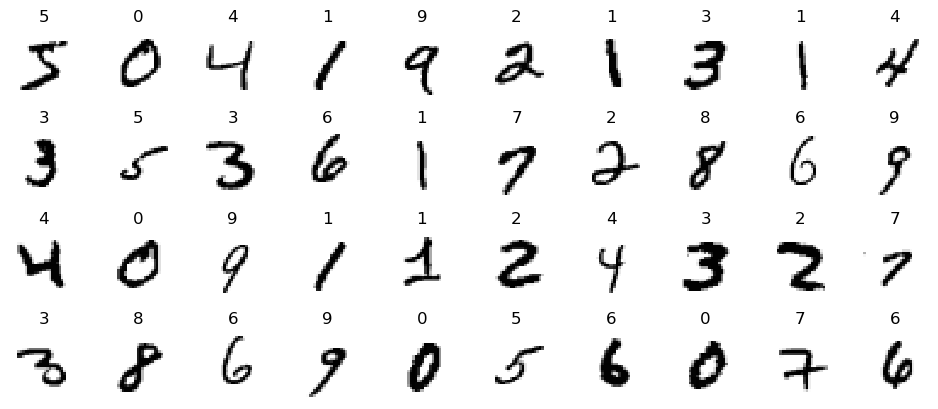

In [5]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## CNN

In [6]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
batch_size = 128
n_epochs=5

In [7]:
model = keras.Sequential(
    [
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

#print(model.summary())

In [8]:
history = model.fit(X_train, y_train, epochs=n_epochs, 
                    batch_size=batch_size, verbose=1, validation_split=.2)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7457 - loss: 0.8137 - val_accuracy: 0.9683 - val_loss: 0.1100
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9590 - loss: 0.1365 - val_accuracy: 0.9802 - val_loss: 0.0758
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9709 - loss: 0.0988 - val_accuracy: 0.9820 - val_loss: 0.0614
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9750 - loss: 0.0812 - val_accuracy: 0.9849 - val_loss: 0.0546
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9791 - loss: 0.0672 - val_accuracy: 0.9856 - val_loss: 0.0502


## Evaluating on test data

In [9]:
# save first for potential re-use
#cnn_model_2.save("fashion_model_dropout.h5py")

test_eval = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9832 - loss: 0.0493
Test loss: 0.04151120036840439
Test accuracy: 0.9858999848365784


## Ploting accuracy and loss between training and validation data

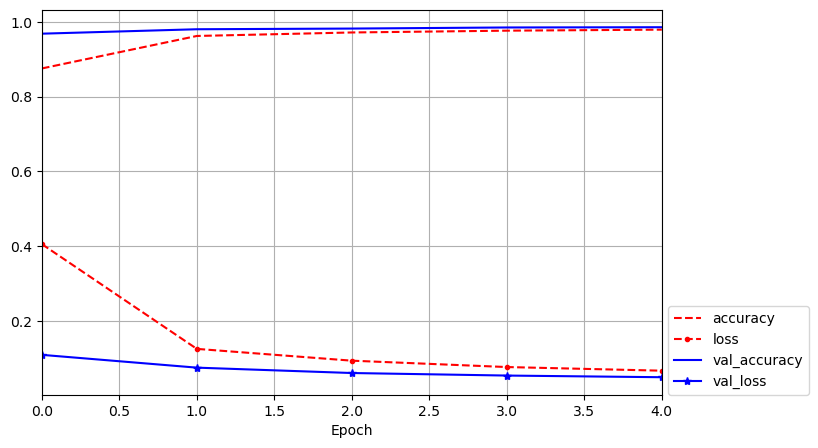

In [10]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0,(n_epochs-1)], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc=(1.01,0))  # extra code
#save_fig("keras_learning_curves_plot")  # extra code
plt.show()

## Predicting labels

In [11]:
predicted_classes = model.predict(X_test)

# Since predictions are floating point values, it will not be feasible to compare  
#predicted labels with true test labels. First, round off output which will convert 
#the float values into an integer. Then, use np.argmax() to select the index number 
#which has a highest value in a row. For example, if prediction for test 
#image is 0 1 0 0 0 0 0 0 0 0, output should be class label 1.

predicted_classes = np.argmax(np.round(predicted_classes), axis=1)
print(predicted_classes.shape, y_test.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000,) (10000, 10)


## Looking at a few correct predictions

In [12]:
# convert back to vector
y_test = y_test.argmax(axis=1)

In [13]:
correct = np.where(predicted_classes == y_test)[0]
print("Found %d correct labels" % len(correct))
X_correct = X_test[correct]
y_correct = y_test[correct]
y_correct_pred = predicted_classes[correct]

Found 9843 correct labels


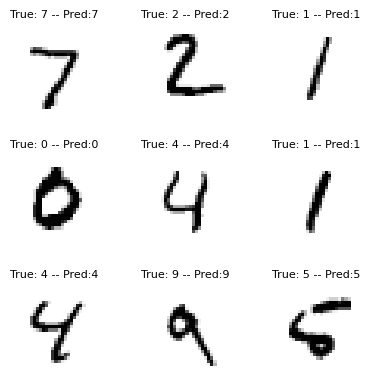

In [14]:
n_rows = 3
n_cols = 3
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_correct[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        title = f"True: {class_names[y_correct[index]]} -- Pred:{class_names[y_correct_pred[index]]}"
        plt.title(title, fontsize=8)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## Looking at a few incorrect predictions

In [15]:
incorrect = np.where(predicted_classes != y_test)[0]
print("Found %d incorrect labels" % len(incorrect))
X_incorrect = X_test[incorrect]
y_incorrect = y_test[incorrect]
y_incorrect_pred = predicted_classes[incorrect]

Found 157 incorrect labels


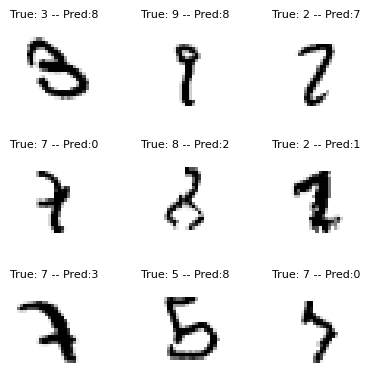

In [16]:
n_rows = 3
n_cols = 3
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_incorrect[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        title = f"True: {class_names[y_incorrect[index]]} -- Pred:{class_names[y_incorrect_pred[index]]}"
        plt.title(title, fontsize=8)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## SHAP

In [ ]:
## For DeepExplainer, we need to pass the model and the background data
## The background data is used to create a reference distribution of SHAP values
## It helps to estimate how the models acts without a specific feature

background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

In [47]:
e = shap.DeepExplainer(model, background)

/Users/sneeley/miniconda3/envs/shared/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/Users/sneeley/miniconda3/envs/shared/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 28, 28, 1))']
  warnings.warn(msg)


In [52]:
shap_values_incorrect = e.shap_values(X_incorrect)

/Users/sneeley/miniconda3/envs/shared/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(157, 28, 28, 1))']
  warnings.warn(msg)


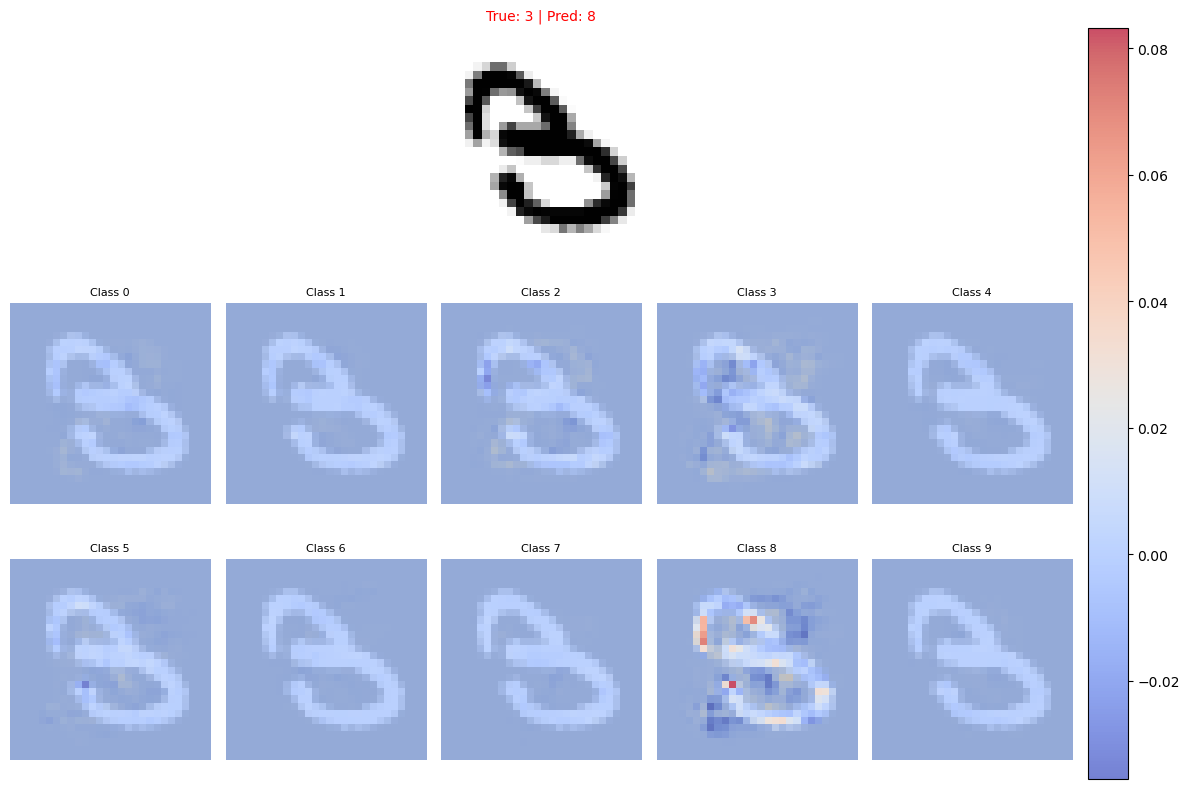

In [58]:
# Example: Plot SHAP for a misclassified sample
mnist_shap_plot(index=0,  # Select any sample (correct or incorrect)
                     X_data=X_incorrect,  # Use incorrect samples or full dataset
                     y_true=y_incorrect,  # True labels
                     y_pred=y_incorrect_pred,  # Predicted labels
                     shap_values=shap_values_incorrect,  # SHAP values (same format as before)
                     class_names=[str(i) for i in range(10)])  # Class names (0-9)